P10|G500|M0.02|ALIVE_CELL_THRESHOLD 0.1|EVERY_10TH_FRAMES

In [ ]:
#############LENIA######################

# Imports
# https://chakazul.github.io/Lenia/JavaScript/Lenia.html
import numpy as np
import time
import warnings
warnings.simplefilter("ignore", UserWarning)
#Imports
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
import matplotlib.animation
import scipy.signal
import os.path
import os
from datetime import datetime
from json import JSONEncoder
import json
from pathlib import Path
                

OUTPUT_PATH = './outputs'
MAX_FRAMES = 3000
mu = 0.31
sigma = 0.057
dt = 0.1
frames = 100
frame_intervals = float(50)
alive_cell_threshold = 0.1



class Lenia:
    def __init__(self, kernel, board):
        self.sigma = sigma
        self.mu = mu
        self.dt = dt
        self.kernel = kernel
        self.normalise_kernel()
        self.frames = frames
        self.frame_intervals = frame_intervals
        self.anim = None
        self.lenia_board_state = {}
        # For random initialisation
        self.board = board
        self.cmap = 'viridis'
        self.fig, self.img = self.show_board()
        

    # FLEXIBLITY TO CHANGE GROWTH FUNCTION
    def growth_function1(self, U:np.array):
        gaussian = lambda x, m, s: np.exp(-( (x-m)**2 / (2*s**2) ))
        return gaussian(U, self.mu, self.sigma)*2-1


    def show_board(self, 
                   display:bool=False,
                   ):
        dpi = 50 # Using a higher dpi will result in higher quality graphics but will significantly affect computation

        self.fig = plt.figure(figsize=(10*np.shape(self.board)[1]/dpi, 10*np.shape(self.board)[0]/dpi), dpi=dpi)

        ax = self.fig.add_axes([0, 0, 1, 1])
        ax.axis('off')
        
        self.img = ax.imshow(self.board, cmap=self.cmap, interpolation='none', aspect=1, vmin=0) #  vmax=vmax
        
        if display:
            plt.show()
        else: # Do not show intermediate figures when creating animations (very slow)
            plt.close()

        return self.fig, self.img
    
    
    def animate(self):
        self.anim =  matplotlib.animation.FuncAnimation(self.fig, self.animate_step, 
                                            frames=self.frames, interval=self.frame_intervals, save_count=MAX_FRAMES, blit=True)

    
    def animate_step(self, i:int) -> plt.imshow:
        neighbours = scipy.signal.convolve2d(self.board, self.kernel, mode='same', boundary='wrap')
        self.board = np.clip(self.board + self.dt * self.growth_function1(neighbours), 0, 1)
        self.record_board_state(i)
        self.img.set_array(self.board) # render the updated state 
        return self.img,
    
    
    def save_animation(self, dir, 
                       filename:str,
                       ):
        if not self.anim:
            raise Exception('ERROR: Run animation before attempting to save')
            return 
        output_path = OUTPUT_PATH+"/"+dir
        Path(output_path).mkdir(parents=True, exist_ok=True)
        fmt = os.path.splitext(filename)[1] # isolate the file extension
        
        if fmt == '.gif':
            f = os.path.join(output_path, filename) 
            writer = matplotlib.animation.PillowWriter(fps=30) 
            self.anim.save(f, writer=writer)
        else:
            raise Exception('ERROR: Unknown save format. Must be .gif or .mp4')
        # writer.close()

    
    def normalise_kernel(self) -> np.array:

        kernel_norm = self.kernel / (1*np.sum(self.kernel))
        self.norm_factor = 1/ (1*np.sum(self.kernel))
        self.kernel = kernel_norm 
        return kernel_norm
        
        
    def plot_kernel_info(self,
                         dir,
                         cmap:str='viridis', 
                         bar:bool=False,
                         save:str=None,
                         ) -> None:

        
        k_xsection = self.kernel[self.kernel.shape[0] // 2, :]
        k_sum = np.sum(self.kernel)
        
        fig, ax = plt.subplots(1, 3, figsize=(14,2), gridspec_kw={'width_ratios': [1,1,2]})
        
        # Show kernel as heatmap
        ax[0].imshow(self.kernel, cmap=cmap, vmin=0)
        ax[0].title.set_text('Kernel')
        
        # Show kernel cross-section
        ax[1].title.set_text('Kernel Cross-section')
        if bar==True:
            ax[1].bar(range(0,len(k_xsection)), k_xsection, width=1)
        else:
            ax[1].plot(k_xsection)
        
        # Growth function
        ax[2].title.set_text('Growth Function')
        x = np.linspace(0, k_sum, 1000)
        ax[2].plot(x, self.growth_function1(x))
        
        if save:
            output_path = OUTPUT_PATH+"/"+dir
            Path(output_path).mkdir(parents=True, exist_ok=True)
            # print('Saving kernel and growth function info to', os.path.join(output_path, 'kernel_info'))
            
            plt.savefig(os.path.join(output_path, 'kernel_info.png') )


    def run_simulation(self, generation) -> None:
        self.animate()
        sub_dir = generation+"/"+str(datetime.now())
        outfile = 'output.gif'   
        # print('./folder/{}...)'.format(sub_dir))
        
        self.save_animation(sub_dir, outfile)
        self.plot_kernel_info(dir=sub_dir, save=True)
        plt.close()
        return self.lenia_board_state


    def record_board_state(self, i):
        board_arr = self.board.flatten()
        board_val_greater_than_point_five = list(board_arr[board_arr > alive_cell_threshold])
        self.lenia_board_state["frame_"+str(i+1)] = len(board_val_greater_than_point_five)


In [ ]:
#############EC######################

import random
import numpy as np
import shutil
import os
# from lenia import Lenia
import statistics
from matplotlib import pyplot as plt
import sys
import copy
import multiprocessing
import time
from datetime import datetime
import pandas as pd


kernel_size = 16
board_size = 64
mutation_rate = 0.02
population_size = 10
generation = 500
gen_best_fitness = {}
gen_average_fitness = {}
each_gen_fitness = []
no_of_elites = 1

def random_kernel_generator():
  grid = np.random.rand(kernel_size, kernel_size)
  grid = np.round(grid, 3)
  return grid

def random_board_generator():
  board = np.random.rand(board_size, board_size)
  board = np.round(board, 3)
  return board

class Individual(multiprocessing.Process):

  def __init__(self):
    self.genes = random_kernel_generator()
    self.fitness = 0

# Every 10th Frame
  def calc_fitness(self, board, gen):
    lenia = Lenia(self.genes, board)
    board_alive_cell = lenia.run_simulation("gen_"+str(gen))
    frame_info = dict(list(board_alive_cell.items())[9::10])
    self.fitness = statistics.pstdev(frame_info.values())
    return self.fitness
    

class Population:
  def __init__(self, size):
    self.individuals = []
    self.board = random_board_generator()
    for _ in range(0, size):
        self.individuals.append(Individual())


class GeneticAlgorithm:

  @staticmethod
  def mutate_individuals(individuals):
    mutated_individuals = []
    for ind in individuals:
        mutated_ind = GeneticAlgorithm._mutate_individual(ind)
        mutated_individuals.append(mutated_ind)
    return mutated_individuals

  @staticmethod
  def _mutate_individual(ind):
    kernel = ind.genes
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            if random.random() < mutation_rate:
                kernel[i][j] = np.round(np.random.rand(), 3)
    ind.genes = kernel
    return ind
    
  @staticmethod
  def select_roulette_wheel(individuals):
    original_individuals = individuals
    individual_length = len(original_individuals)
    new_individuals = []
    total_sum = 0
    total_sum = sum([(total_sum + ind.fitness) for ind in individuals])
    random_num = random.randrange(0,int(round(total_sum)))
    partial_sum = 0
    while len(new_individuals) != individual_length - no_of_elites:
        for c in original_individuals:
            partial_sum += c.fitness
            if(partial_sum >= random_num):
                new_individuals.append(c)
                random_num = random.randrange(0,int(round(total_sum)))
                partial_sum = 0
                break
    print("Roulette - Selected Individuals Fitness: ",  [ind.fitness for ind in new_individuals])
    return new_individuals

def move_elite(dir):
  main_elite_dir = "elite_dir"
  if not os.path.isdir(main_elite_dir):
    os.makedirs(main_elite_dir)
  
  main_dir, sub_dir = os.path.split(dir)
  shutil.move(OUTPUT_PATH +"/"+ dir, main_elite_dir+'/'+main_dir)
  

def run_ga(pop_size, generation):
  population = Population(pop_size)
  board = population.board
  population.individuals.sort(key=lambda x: x.calc_fitness(board=board, gen=1), reverse= True)
  df = pd.DataFrame(columns=[
                      'gen', 'gen_best_fitness', 'gen_average_fitness'], index=[0])
  for gen in range(1, generation+1):
      print("Generation: ", gen, " started")
      df.loc[gen - 1, 'gen'] = gen
      gen_fitness_dict = {}
      gen_best_fitness["gen_"+str(gen)] = population.individuals[0].fitness
      print("Best gen dir: ", population.individuals[0].gif_dir)
      if os.path.isdir(OUTPUT_PATH +"/"+ population.individuals[0].gif_dir):
        move_elite(population.individuals[0].gif_dir)
      shutil.rmtree(OUTPUT_PATH +"/"+ "gen_"+str(gen))
      df.loc[gen - 1, 'gen_best_fitness'] = population.individuals[0].fitness
      gif_dir = population.individuals[0].gif_dir
      all_fitness = [ind.fitness for ind in population.individuals]
      gen_fitness_dict["gen_"+str(gen)] = all_fitness
      print("Fitness of this generation: ", all_fitness)
      each_gen_fitness.append(gen_fitness_dict)
      gen_average_fitness["gen_"+str(gen)] = sum(all_fitness)/len(all_fitness)
      df.loc[gen - 1, 'gen_average_fitness'] = sum(all_fitness)/len(all_fitness)
      elite_individuals = [copy.deepcopy(population.individuals[i]) for i in range(0,no_of_elites)]
      selected_individuals = GeneticAlgorithm.select_roulette_wheel(population.individuals)
      mutated_individuals = GeneticAlgorithm.mutate_individuals(selected_individuals)
      for ind in mutated_individuals:
        ind.calc_fitness(board, gen + 1)
      # print("Mutated population fitness: ",  [ind.fitness for ind in mutated_individuals])
      population.individuals = elite_individuals + mutated_individuals    
      population.individuals.sort(key=lambda x: x.fitness, reverse= True)
      print("elite fitness: ", [ind.fitness for ind in elite_individuals])
      # print("Next generation fitness : ", [ind.fitness for ind in population.individuals])
      print("Generation ",gen, " completed")
      print("----------------------------------")
      print("----------------------------------")

  df.to_csv('P10|G500|M0.02|ALIVE_CELL_THRESHOLD0.1|EVERY_10TH_FRAMES.csv', index=False)


def plot_figures(data, name):
  plt.clf()
  labels = list(data.keys())
  values = list(data.values())
  plt.plot(labels, values)
  plt.xlabel('Generation')
  plt.ylabel('Fitness')
  plt.title('Fitness of Generations')
  plt.savefig(name) 


Generation:  1  started
Fitness of this generation:  [292.36041113666533, 239.3391735591982, 238.34775014671317, 232.31024514644204, 227.15413269408066, 217.2671397151442, 214.22240779152867, 213.5242609166462, 178.73097101509856, 158.96619137414095]
Roulette - Selected Individuals Fitness:  [292.36041113666533, 178.73097101509856, 217.2671397151442, 292.36041113666533, 239.3391735591982, 213.5242609166462, 213.5242609166462, 232.31024514644204, 178.73097101509856]
Mutated population fitness:  [290.91950776804225, 182.80743967355377, 217.8325044615702, 290.91950776804225, 253.48325388474876, 212.88644860582366, 212.88644860582366, 231.21020738713074, 182.80743967355377]
elite fitness:  [292.36041113666533]
Next generation fitness :  [292.36041113666533, 290.91950776804225, 290.91950776804225, 253.48325388474876, 231.21020738713074, 217.8325044615702, 212.88644860582366, 212.88644860582366, 182.80743967355377, 182.80743967355377]
Generation  1  completed
--------------------------------

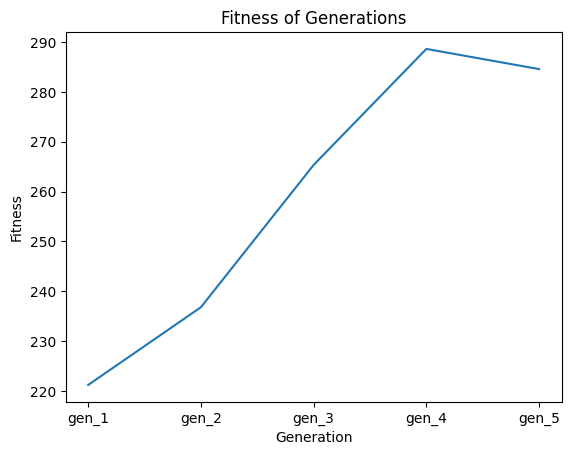

In [ ]:
start_time = datetime.now()  
if os.path.exists('outputs'):
  shutil.rmtree('outputs')
run_ga(population_size, generation)
end_time = datetime.now()
print("The total time taken: ", end_time - start_time)